In [33]:
import timeit
import datetime as dt
import os
import subprocess 

import pandas as pd
import numpy as np

#for portofolio optimization 
import scipy.optimize as sco


#visualization
import matplotlib.pyplot as plt
#import plotly.graph_objs as go
%matplotlib inline
#visualization with seaborn
import seaborn as sns
#visualization with plotly 
import plotly.graph_objects as go #for candle chart visualization
import plotly.express as px #for html output


#to get financial data
from pandas_datareader import data as pdr


#for webscraping 
import requests
from bs4 import BeautifulSoup 
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import pandas as pd
import requests


#for pdf report generation
from reportlab.pdfgen import canvas
from reportlab.platypus import *
from reportlab.lib import colors
from reportlab.lib.pagesizes import letter, landscape
from reportlab.lib.styles import getSampleStyleSheet, ParagraphStyle
from reportlab.lib.units import inch
from reportlab.platypus.tableofcontents import TableOfContents


In [2]:
days_to_lookback = int (input('days to search financial data:'))

days to search financial data:20


In [3]:
date_end = dt.datetime.now() #.today()
date_start = date_end - dt.timedelta(days_to_lookback)

# Create timestamped folder to save reports created later

In [4]:
#timestamp = str(dt.datetime.now()) <- '2020-06-26 20:26:08.775766'  
timestamp =  dt.datetime.now().strftime('%Y-%m-%d %H-%M-%S')
timestamp

'2020-07-03 09-14-39'

In [5]:
path = os.getcwd() 
reportDir = os.path.join(path,timestamp)
reportDir

'/Users/reejungkim/Documents/Git/reporting automation/2020-07-03 09-14-39'

In [6]:
#create named folder
os.makedirs(reportDir, exist_ok = False)

In [7]:
os.chdir(reportDir)

# Web scraping S&P100 companies from Wikipedia table

In [8]:
website_url = requests.get("https://en.wikipedia.org/wiki/S%26P_100").text

soup = BeautifulSoup(website_url,'lxml')
#print(soup.prettify())

In [9]:
wiki_table = soup.find('table',{'class':'wikitable sortable'})

In [10]:
data = []
tHeader = []
SP100_tickers = pd.DataFrame()

for tr in wiki_table.find_all("tr"):
    for th in tr.find_all("th")[:1]:
        tHeader = th.get_text(strip=True)
        SP100_tickers[tHeader] = []
    for td in tr.find_all("td")[:1]:
        data.append( td.get_text(strip=True))
        
SP100_tickers[tHeader] = data

In [11]:
SP100_tickers

,Symbol
0,AAPL
1,ABBV
2,ABT
3,ACN
4,ADBE
...,...
96,VZ
97,WBA
98,WFC
99,WMT


# Use DataReader to get financial data of S&P100 companies from yahoo

In [12]:
%%time

df = pd.DataFrame()

for i in data:
    symbol = SP100_tickers.loc[SP100_tickers['Symbol']==i]
    try:
        symbol_data = pdr.DataReader(i, 'yahoo', date_start, date_end).reset_index()
        #display(symbol_data)  
    except (KeyError, ValueError):  # the error could possibly occur when there's "." in stock name 
        symbol_data = pdr.DataReader(i.replace('.','-'), 'yahoo', date_start, date_end).reset_index()
        #symbol_data = pd.DataFrame()
        pass
    except:
        print(i + " - Error.")
        symbol_data = pd.DataFrame()
        pass
    single_table = pd.concat([symbol, symbol_data], axis=0, ignore_index=True) #axis=0 <- row. add frames by row and use fill down.
    single_table['Symbol'].ffill(inplace=True)
    df = df.append(single_table)
    

PM - Error.
CPU times: user 6.34 s, sys: 538 ms, total: 6.88 s
Wall time: 2min 15s


In [13]:
df = df.loc[df['Date'].notnull()]

In [14]:
df = df.reset_index(drop=True)

df.groupby(['Symbol']).describe().transpose()

In [15]:
df_Flat = df

In [16]:
symbols = ['AAPL', 'MSFT', 'YHOO', 'DB', 'GLD']

In [17]:
d = df.pivot_table(values='Close', index='Date', columns='Symbol', aggfunc=np.sum, margins=False)
d


Symbol,AAPL,ABBV,ABT,ACN,ADBE,AIG,ALL,AMGN,AMT,AMZN,...,UNH,UNP,UPS,USB,V,VZ,WBA,WFC,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2020-06-15,342.989990,93.080002,89.550003,199.789993,401.339996,33.189999,97.830002,219.779999,262.489990,2572.679932,...,286.279999,167.929993,105.639999,38.779999,191.759995,56.150002,41.490002,28.209999,118.080002,47.139999
2020-06-16,352.079987,96.059998,89.739998,204.399994,411.670013,33.290001,99.120003,226.869995,264.779999,2615.270020,...,293.000000,170.970001,105.830002,39.340000,192.880005,56.919998,42.150002,28.520000,119.650002,48.200001
2020-06-17,351.589996,95.739998,90.900002,205.199997,413.489990,32.279999,97.949997,225.970001,263.970001,2640.979980,...,292.600006,171.169998,106.989998,38.509998,193.559998,56.650002,42.150002,27.450001,119.029999,46.630001
2020-06-18,351.730011,96.230003,90.279999,202.929993,420.459991,32.470001,98.750000,230.320007,257.600006,2653.979980,...,291.480011,170.850006,107.580002,38.570000,193.910004,56.889999,41.980000,27.549999,117.989998,46.919998
2020-06-19,349.720001,96.709999,90.680000,201.550003,428.010010,31.809999,98.730003,238.699997,265.600006,2675.010010,...,291.239990,167.850006,107.769997,38.869999,192.199997,56.160000,44.130001,27.600000,119.849998,45.980000
2020-06-22,358.869995,97.269997,90.339996,202.600006,438.640015,31.790001,97.160004,234.190002,264.600006,2713.820068,...,292.670013,168.199997,106.900002,38.220001,194.960007,55.660000,43.240002,27.350000,121.680000,46.419998
2020-06-23,366.529999,97.309998,91.300003,207.399994,440.549988,32.049999,96.660004,235.750000,264.500000,2764.409912,...,297.600006,169.360001,110.610001,38.599998,197.970001,54.939999,42.810001,27.230000,121.070000,46.700001
2020-06-24,360.059998,95.139999,87.300003,201.839996,431.679993,30.299999,92.949997,232.509995,254.179993,2734.399902,...,289.179993,165.550003,109.500000,36.869999,191.410004,53.930000,41.169998,26.120001,120.300003,44.500000
2020-06-25,364.839996,96.989998,89.620003,217.320007,436.950012,31.260000,95.830002,235.110001,254.360001,2754.580078,...,296.220001,167.020004,110.519997,38.049999,193.979996,54.279999,42.040001,27.370001,119.709999,45.169998


In [18]:
logChange = np.log(d / d.shift(1)) # geometric brownian motion. - make the errors being normally distributed.
# more standardly used than pct_change.  df_temp['Close'] in this case.
logChange

Symbol,AAPL,ABBV,ABT,ACN,ADBE,AIG,ALL,AMGN,AMT,AMZN,...,UNH,UNP,UPS,USB,V,VZ,WBA,WFC,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2020-06-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-06-16,0.026157,0.031514,0.002119,0.022812,0.025413,0.003008,0.013100,0.031750,0.008686,0.016419,...,0.023202,0.017941,0.001797,0.014337,0.005824,0.013620,0.015782,0.010929,0.013208,0.022237
2020-06-17,-0.001393,-0.003337,0.012843,0.003906,0.004411,-0.030809,-0.011874,-0.003975,-0.003064,0.009783,...,-0.001366,0.001169,0.010901,-0.021324,0.003519,-0.004755,0.000000,-0.038239,-0.005195,-0.033115
2020-06-18,0.000398,0.005105,-0.006844,-0.011124,0.016716,0.005869,0.008134,0.019067,-0.024427,0.004910,...,-0.003835,-0.001871,0.005499,0.001557,0.001807,0.004228,-0.004041,0.003636,-0.008776,0.006200
2020-06-19,-0.005731,0.004976,0.004421,-0.006824,0.017797,-0.020536,-0.000203,0.035738,0.030583,0.007893,...,-0.000824,-0.017715,0.001765,0.007748,-0.008858,-0.012915,0.049947,0.001813,0.015641,-0.020237
2020-06-22,0.025827,0.005774,-0.003757,0.005196,0.024532,-0.000629,-0.016030,-0.019075,-0.003772,0.014404,...,0.004898,0.002083,-0.008105,-0.016864,0.014258,-0.008943,-0.020374,-0.009099,0.015154,0.009524
2020-06-23,0.021120,0.000411,0.010571,0.023416,0.004345,0.008145,-0.005159,0.006639,-0.000378,0.018470,...,0.016705,0.006873,0.034117,0.009893,0.015321,-0.013020,-0.009994,-0.004397,-0.005026,0.006014
2020-06-24,-0.017810,-0.022552,-0.044800,-0.027174,-0.020339,-0.056149,-0.039138,-0.013839,-0.039799,-0.010915,...,-0.028701,-0.022753,-0.010086,-0.045854,-0.033698,-0.018555,-0.039062,-0.041618,-0.006380,-0.048255
2020-06-25,0.013188,0.019258,0.026228,0.073896,0.012134,0.031192,0.030514,0.011120,0.000708,0.007353,...,0.024053,0.008840,0.009272,0.031503,0.013337,0.006469,0.020912,0.046746,-0.004917,0.014944


In [19]:
logChange.mean()*252 #252 business days per year in general

Symbol
AAPL    1.158322
ABBV    1.171754
ABT     0.571620
ACN     1.487081
ADBE    1.912253
          ...   
VZ     -0.475291
WBA     0.227591
WFC    -2.079820
WMT     0.184624
XOM    -1.301012
Length: 100, dtype: float64

In [20]:
logChange.cov()*252

Symbol,AAPL,ABBV,ABT,ACN,ADBE,AIG,ALL,AMGN,AMT,AMZN,...,UNH,UNP,UPS,USB,V,VZ,WBA,WFC,WMT,XOM
Symbol,,,,,,,,,,,,,,,,,,,,,
AAPL,0.075904,0.038211,0.036919,0.066584,0.044771,0.101614,0.039856,0.002515,0.050031,0.034679,...,0.064859,0.056434,0.040259,0.078368,0.055968,0.038656,0.035027,0.096291,0.023267,0.085146
ABBV,0.038211,0.046158,0.041137,0.056415,0.043409,0.058322,0.049902,0.043838,0.044979,0.033438,...,0.050162,0.034494,0.019820,0.062854,0.033071,0.028046,0.036002,0.067687,0.016634,0.058093
ABT,0.036919,0.041137,0.081298,0.081305,0.042261,0.087165,0.061550,0.032833,0.063548,0.038500,...,0.061025,0.047111,0.039127,0.080958,0.053249,0.028406,0.062215,0.075260,0.008194,0.060408
ACN,0.066584,0.056415,0.081305,0.160731,0.045690,0.127726,0.081791,0.020082,0.046088,0.036452,...,0.088387,0.059950,0.043447,0.119520,0.065225,0.035791,0.061804,0.144879,0.006164,0.092357
ADBE,0.044771,0.043409,0.042261,0.045690,0.065088,0.061611,0.039036,0.044681,0.047815,0.048554,...,0.052718,0.036295,0.023672,0.068025,0.041761,0.020399,0.037936,0.076647,0.024005,0.060077
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VZ,0.038656,0.028046,0.028406,0.035791,0.020399,0.083852,0.043805,0.007343,0.038526,0.008827,...,0.038641,0.046257,0.022213,0.058208,0.031579,0.049585,0.049150,0.073492,0.009790,0.061142
WBA,0.035027,0.036002,0.062215,0.061804,0.037936,0.127223,0.072270,0.015031,0.080548,-0.008657,...,0.049189,0.047370,0.011922,0.115654,0.036829,0.049150,0.177393,0.129459,0.026270,0.074656
WFC,0.096291,0.067687,0.075260,0.144879,0.076647,0.201318,0.099957,0.049210,0.087224,0.044855,...,0.109181,0.085758,0.062150,0.178199,0.083204,0.073492,0.129459,0.239154,0.026833,0.146132


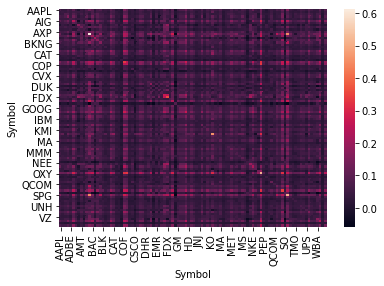

In [21]:
sns.heatmap(logChange.cov()*252)

In [22]:
np.random.seed(0)
weights = np.random.random(df.Symbol.nunique())
weights /= np.sum(weights)
weights

array([1.16078819e-02, 1.51268757e-02, 1.27489685e-02, 1.15247522e-02,
       8.96066666e-03, 1.36612210e-02, 9.25534926e-03, 1.88617729e-02,
       2.03823037e-02, 8.11012088e-03, 1.67456716e-02, 1.11865865e-02,
       1.20146354e-02, 1.95771721e-02, 1.50247428e-03, 1.84286030e-03,
       4.27636652e-04, 1.76106323e-02, 1.64586906e-02, 1.84015119e-02,
       2.06986272e-02, 1.69028971e-02, 9.76068899e-03, 1.65088694e-02,
       2.50160675e-03, 1.35348849e-02, 3.03204643e-03, 1.99805674e-02,
       1.10375449e-02, 8.77045988e-03, 5.59558078e-03, 1.63757144e-02,
       9.64797538e-03, 1.20228713e-02, 3.97420585e-04, 1.30635268e-02,
       1.29463557e-02, 1.30486894e-02, 1.99610909e-02, 1.44210910e-02,
       7.60390408e-03, 9.24360508e-03, 1.47555052e-02, 1.27382099e-03,
       1.41026947e-02, 1.41845729e-02, 4.44977374e-03, 2.72690308e-03,
       6.67158335e-03, 7.69279844e-03, 1.20601565e-02, 9.27680263e-03,
       2.09049644e-02, 2.15833630e-03, 4.41792466e-03, 3.41183629e-03,
      

#### Expected return:
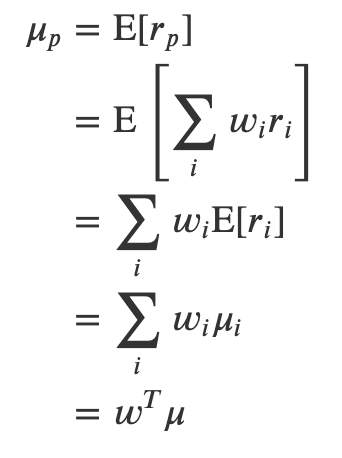

In [23]:
#return of portfolio
np.sum(logChange.mean()*weights)*252

0.013296984996292109

In [25]:
#variance of portfolio
np.dot(weights.T, np.dot(logChange.cov() * 252, weights))

0.05267298449142297

In [26]:
#standard deviation of portfolio (volatility)
np.sqrt(np.dot(weights.T, np.dot(logChange.cov() * 252, weights)))

0.2295059574203314

## simulation

In [27]:
prets = []  #stores list of returns
pvols = []  #stores list of volatilities
for p in range (2500):
    weights = np.random.random(df.Symbol.nunique())
    weights /= np.sum(weights)
    prets.append(np.sum(logChange.mean() * weights) * 252)
    pvols.append(np.sqrt(np.dot(weights.T, 
                        np.dot(logChange.cov() * 252, weights))))
prets = np.array(prets)
pvols = np.array(pvols)

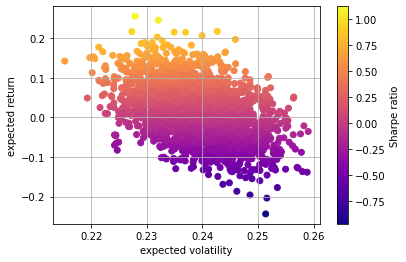

In [31]:

plt.scatter(pvols, prets, c=prets/pvols, marker='o', cmap='plasma')

plt.grid(True)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio') #beta
plt.show()

In [35]:
def statistics(weights):
    ''' Return portfolio statistics.
    
    Parameters
    ==========
    weights : array-like
        포트폴리오 내의 증권 비중
    
    Returns
    =======
    pret : float
        포트폴리오 수익률의 기댓값
    pvol : float
        포트폴리오 변동성의 기댓값
    pret / pvol : float
        무위험 이자율이 0일 때의 포트폴리오 샤프 지수
    '''
    weights = np.array(weights)
    pret = np.sum(logChange.mean() * weights) * 252
    pvol = np.sqrt(np.dot(weights.T, np.dot(logChange.cov() * 252, weights)))
    return np.array([pret, pvol, pret / pvol])

## Sharp ratio optimization

In [36]:
def min_func_sharpe(weights):
    return -statistics(weights)[2]

In [44]:
cons = ({'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})
cons

{'type': 'eq', 'fun': <function __main__.<lambda>(x)>}

In [46]:
bnds = tuple((0, 1) for x in range(df.Symbol.nunique()))
bnds

((0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1))

In [52]:
df.Symbol.nunique()* [1./ df.Symbol.nunique()]

[0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01]

In [ ]:
%%time
opts = sco.minimize(min_func_sharpe, noa * [1. / noa,], method='SLSQP',
                       bounds=bnds, constraints=cons)

# Analytics

###  main data frames to be used: 
#### 1. df_Flat
#### 2. df  
#### 3. df_Flat_pct_change

In [50]:
df_Flat

,Symbol,Date,High,Low,Open,Close,Volume,Adj Close
0,AAPL,2020-06-15,345.679993,332.579987,333.250000,342.989990,34702200.0,342.989990
1,AAPL,2020-06-16,353.200012,344.720001,351.459991,352.079987,41357200.0,352.079987
2,AAPL,2020-06-17,355.399994,351.089996,355.149994,351.589996,28532000.0,351.589996
3,AAPL,2020-06-18,353.450012,349.220001,351.410004,351.730011,24205100.0,351.730011
4,AAPL,2020-06-19,356.559998,345.149994,354.640015,349.720001,66119000.0,349.720001
...,...,...,...,...,...,...,...,...
1409,XOM,2020-06-26,44.939999,43.500000,44.880001,43.619999,31518600.0,43.619999
1410,XOM,2020-06-29,44.580002,43.540001,43.810001,44.320000,17052100.0,44.320000
1411,XOM,2020-06-30,44.970001,43.160000,43.430000,44.720001,22153600.0,44.720001
1412,XOM,2020-07-01,45.380001,43.669998,44.490002,43.709999,17276100.0,43.709999


In [51]:
df = df.groupby(['Symbol', 'Date']).sum()

df

High         Low        Open       Close      Volume  \
Symbol Date                                                                     
AAPL   2020-06-15  345.679993  332.579987  333.250000  342.989990  34702200.0   
       2020-06-16  353.200012  344.720001  351.459991  352.079987  41357200.0   
       2020-06-17  355.399994  351.089996  355.149994  351.589996  28532000.0   
       2020-06-18  353.450012  349.220001  351.410004  351.730011  24205100.0   
       2020-06-19  356.559998  345.149994  354.640015  349.720001  66119000.0   
...                       ...         ...         ...         ...         ...   
XOM    2020-06-26   44.939999   43.500000   44.880001   43.619999  31518600.0   
       2020-06-29   44.580002   43.540001   43.810001   44.320000  17052100.0   
       2020-06-30   44.970001   43.160000   43.430000   44.720001  22153600.0   
       2020-07-01   45.380001   43.669998   44.490002   43.709999  17276100.0   
       2020-07-02   45.185001   43.930000   44.619999   44.080002  14984334.0   

                    Adj Close  
Symbol Date                    
AAPL   2020-06-15  342.989990  
       2020-06-16  352.079987  
       2020-06-17  351.589996  
       2020-06-18  351.730011  
       2020-06-19  349.720001  
...                       ...  
XOM    2020-06-26   43.619999  
       2020-06-29   44.320000  
       2020-06-30   44.720001  
       2020-07-01   43.709999  
       2020-07-02   44.080002  

[1414 rows x 6 columns]

In [61]:
df_Flat.groupby('Symbol')['Close'].pct_change()

0            NaN
1       0.026502
2      -0.001392
3       0.000398
4      -0.005715
          ...   
1409   -0.034315
1410    0.016048
1411    0.009025
1412   -0.022585
1413    0.008465
Name: Close, Length: 1414, dtype: float64

In [52]:
df_Flat_pct_change = pd.DataFrame()

for i in df_Flat.columns.tolist():
    if i !="Symbol" and i!="Date" :
        data = df_Flat.groupby('Symbol')[i].pct_change()
        df_Flat_pct_change[i] = data

df_Flat_pct_change['Symbol'] = df_Flat['Symbol']
df_Flat_pct_change['Date'] = df_Flat['Date']

df_Flat_pct_change
cols = df_Flat.columns.tolist()
df_Flat_pct_change = df_Flat_pct_change[cols]

df_Flat_pct_change

,Symbol,Date,High,Low,Open,Close,Volume,Adj Close
0,AAPL,2020-06-15,NaN,NaN,NaN,NaN,NaN,NaN
1,AAPL,2020-06-16,0.021754,0.036503,0.054644,0.026502,0.191775,0.026502
2,AAPL,2020-06-17,0.006229,0.018479,0.010499,-0.001392,-0.310108,-0.001392
3,AAPL,2020-06-18,-0.005487,-0.005326,-0.010531,0.000398,-0.151651,0.000398
4,AAPL,2020-06-19,0.008799,-0.011655,0.009192,-0.005715,1.731614,-0.005715
...,...,...,...,...,...,...,...,...
1409,XOM,2020-06-26,-0.006631,-0.004349,0.018842,-0.034315,0.628565,-0.034315
1410,XOM,2020-06-29,-0.008011,0.000920,-0.023841,0.016048,-0.458983,0.016048
1411,XOM,2020-06-30,0.008748,-0.008728,-0.008674,0.009025,0.299171,0.009025
1412,XOM,2020-07-01,0.009117,0.011816,0.024407,-0.022585,-0.220167,-0.022585


In [53]:
df_temp = df.unstack(level=0).pct_change()  #df.groupby(['Symbol', 'Date']).sum().pct_change()

df_temp

High                                                    \
Symbol          AAPL      ABBV       ABT       ACN      ADBE       AIG   
Date                                                                     
2020-06-15       NaN       NaN       NaN       NaN       NaN       NaN   
2020-06-16  0.021754  0.023078  0.015606  0.030587  0.021103  0.057492   
2020-06-17  0.006229  0.009356 -0.000981 -0.002659  0.006704 -0.061127   
2020-06-18 -0.005487 -0.006694 -0.003600 -0.015315  0.008097 -0.009901   
2020-06-19  0.008799  0.018144  0.011605  0.025201  0.020031  0.010909   
2020-06-22  0.008133 -0.009165 -0.018939 -0.020212  0.022550 -0.039269   
2020-06-23  0.035943  0.018499  0.018202  0.027440  0.016403  0.021217   
2020-06-24 -0.009641 -0.019576 -0.017010 -0.010874 -0.007800 -0.033303   
2020-06-25 -0.010277 -0.000926 -0.010140  0.050579 -0.010572 -0.009482   
2020-06-26  0.000877 -0.000412  0.001559 -0.004406  0.000434 -0.014678   
2020-06-29 -0.008623  0.003092 -0.002779 -0.016319 -0.022137  0.000324   
2020-06-30  0.010520  0.015925  0.024526  0.010544  0.019674  0.016510   
2020-07-01  0.003771  0.007888  0.000871  0.005843  0.011764  0.005414   
2020-07-02  0.008466  0.003311  0.011742  0.007100  0.013788 -0.011403   

                                                    ... Adj Close            \
Symbol           ALL      AMGN       AMT      AMZN  ...       UNH       UNP   
Date                                                ...                       
2020-06-15       NaN       NaN       NaN       NaN  ...       NaN       NaN   
2020-06-16  0.027131  0.035656  0.021742  0.013932  ...  0.023474  0.018103   
2020-06-17 -0.014147 -0.000306 -0.001488  0.013359  ... -0.001365  0.001170   
2020-06-18 -0.006322  0.011669 -0.023733  0.001748  ... -0.003828 -0.001869   
2020-06-19  0.019996  0.032789  0.014655  0.014209  ...  0.003480 -0.017559   
2020-06-22 -0.023960 -0.005940  0.003648  0.006514  ...  0.004910  0.002085   
2020-06-23  0.007101  0.006396 -0.000075  0.025087  ...  0.016845  0.006897   
2020-06-24 -0.034045 -0.009073 -0.013642  0.004631  ... -0.028293 -0.022496   
2020-06-25 -0.000209 -0.006582 -0.027510 -0.014224  ...  0.024345  0.008879   
2020-06-26 -0.001877  0.006031  0.008400  0.009557  ... -0.031531 -0.026224   
2020-06-29  0.001881 -0.011484 -0.014065 -0.030824  ...  0.010039  0.017646   
2020-06-30  0.018773  0.013582  0.018313  0.027006  ...  0.017911  0.021509   
2020-07-01 -0.002559  0.079681  0.029291  0.045266  ...  0.009425 -0.012953   
2020-07-02 -0.001745  0.020138  0.006037  0.020919  ...  0.000907  0.013123   

                                                                        \
Symbol           UPS       USB         V        VZ       WBA       WFC   
Date                                                                     
2020-06-15       NaN       NaN       NaN       NaN       NaN       NaN   
2020-06-16  0.001799  0.014440  0.005841  0.013713  0.015907  0.010989   
2020-06-17  0.010961 -0.021098  0.003525 -0.004743  0.000000 -0.037518   
2020-06-18  0.005515  0.001558  0.001808  0.004237 -0.004033  0.003643   
2020-06-19  0.001766  0.007778 -0.008819 -0.012832  0.051215  0.001815   
2020-06-22 -0.008073 -0.016722  0.014360 -0.008903 -0.020168 -0.009058   
2020-06-23  0.034705  0.009942  0.015439 -0.012936 -0.009945 -0.004388   
2020-06-24 -0.010035 -0.044819 -0.033136 -0.018384 -0.038309 -0.040764   
2020-06-25  0.009315  0.032004  0.013427  0.006490  0.021132  0.047856   
2020-06-26 -0.028954 -0.052300 -0.024281 -0.020634 -0.020695 -0.074169   
2020-06-29  0.020127  0.019921  0.011148  0.028781  0.027933  0.014207   
2020-06-30  0.015528  0.012930  0.009353  0.008045  0.001654 -0.003891   
2020-07-01  0.029142 -0.022814  0.003158 -0.008344 -0.035622 -0.019922   
2020-07-02 -0.000262 -0.002501  0.008979  0.002195  0.026908  0.010363   

                                
Symbol           WMT       XOM  
Date                            
2020-06-15       NaN       NaN  
2020-06-16  0.013296  

## Functions defined

In [20]:
def format_column_number(dataframe, listCols):
    for col in listCols:
        try:
            dataframe[col]= pd.Series([round(val, 2 ) for val in dataframe[col]], index= dataframe.index)
        except ValueError:  #skips error when the column is in format already
            dataframe[col] = dataframe[col]
            pass
    return dataframe

def format_column_percentage(dataframe, listCols):
    for col in listCols:
        try:
            dataframe[col] = pd.Series(["{0:.2f}%".format(val*100) for val in dataframe[col]], index= dataframe.index)
        except ValueError:  #skips error when the column is in format already
            dataframe[col] = dataframe[col]
        
    return dataframe

In [21]:
def CreatePctPlotAndSavefig(listTickers, stringTitle, stringYlabel, jpg_name):
    sns.relplot(x='Date', y='Close', kind='line', hue ='Symbol',data=df_Flat_pct_change.groupby(['Symbol', 'Date']).sum().loc[listTickers].reset_index()).fig.autofmt_xdate()
    plt.grid(which="major", color='k', linestyle='-.', linewidth=0.5)
    plt.title(stringTitle, fontsize=16)
    plt.ylabel(stringYlabel, fontsize=14)
    plt.xlabel('Date', fontsize=14)
    #plt.tight_layout()

    jpg_name = jpg_name + '.jpg'
    plt.savefig(jpg_name, bbox_inches='tight')

def CreatePlotAndSavefig(listTickers, stringTitle, stringYlabel, jpg_name):
    sns.relplot(x='Date', y='Close', kind='line', hue ='Symbol',data=df.loc[listTickers].reset_index()).fig.autofmt_xdate()
    plt.grid(which="major", color='k', linestyle='-.', linewidth=0.5)
    plt.title(stringTitle, fontsize=16)
    plt.ylabel(stringYlabel, fontsize=14)
    plt.xlabel('Date', fontsize=14)

    jpg_name = jpg_name + '.jpg'
    plt.savefig(jpg_name, bbox_inches='tight')

### Best performed tickers based on percentage of of growth

In [22]:
tickers_bestPerformed = df_temp['Close'].describe().transpose().sort_values(by='mean', ascending=False).head(5) #df_pct_change['Close'].describe().transpose().sort_values(by='mean', ascending=False).head(5)

In [23]:
tickers_bestPerformed

,count,mean,std,min,25%,50%,75%,max
Symbol,,,,,,,,
LLY,14.0,0.006603,0.046880,-0.045828,-0.012308,-0.002212,0.003977,0.156798
PYPL,14.0,0.006005,0.024581,-0.042962,-0.013423,0.014805,0.025142,0.035897
ADBE,14.0,0.004578,0.024556,-0.047072,-0.011186,0.008315,0.018262,0.048675
NFLX,14.0,0.003820,0.022839,-0.048314,-0.014151,0.008609,0.020374,0.031561
AMZN,14.0,0.002764,0.016424,-0.033802,-0.004954,0.007652,0.013598,0.024817


In [24]:
for i in range(len(tickers_bestPerformed.index)):
    fig = go.Figure(data=[go.Candlestick(x= df_Flat.loc[df_Flat['Symbol']==tickers_bestPerformed.index[i]]['Date'],
                open= df_Flat.loc[df_Flat['Symbol']==tickers_bestPerformed.index[i]]['Open'],
                high= df_Flat.loc[df_Flat['Symbol']==tickers_bestPerformed.index[i]]['High'],
                low= df_Flat.loc[df_Flat['Symbol']==tickers_bestPerformed.index[i]]['Low'],
                close= df_Flat.loc[df_Flat['Symbol']==tickers_bestPerformed.index[i]]['Close'])])

    fig.update_layout(xaxis_rangeslider_visible=False)
    #fig.show()
    fig_name = 'candle chart ' + tickers_bestPerformed.index[i] + '.html'
    fig.write_html(fig_name)
    

In [25]:
tickers_bestPerformed = format_column_percentage(tickers_bestPerformed, tickers_bestPerformed.columns[1:])
tickers_bestPerformed

,count,mean,std,min,25%,50%,75%,max
Symbol,,,,,,,,
LLY,14.0,0.66%,4.69%,-4.58%,-1.23%,-0.22%,0.40%,15.68%
PYPL,14.0,0.60%,2.46%,-4.30%,-1.34%,1.48%,2.51%,3.59%
ADBE,14.0,0.46%,2.46%,-4.71%,-1.12%,0.83%,1.83%,4.87%
NFLX,14.0,0.38%,2.28%,-4.83%,-1.42%,0.86%,2.04%,3.16%
AMZN,14.0,0.28%,1.64%,-3.38%,-0.50%,0.77%,1.36%,2.48%


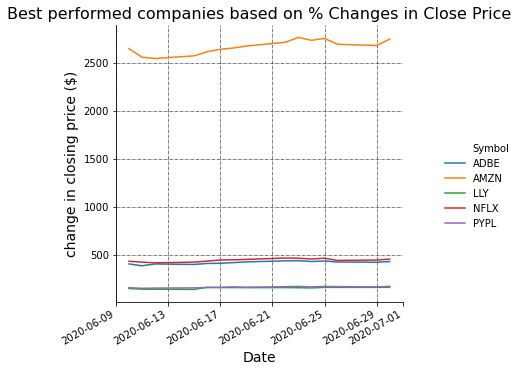

In [26]:
CreatePlotAndSavefig(tickers_bestPerformed.index, 'Best performed companies based on % Changes in Close Price', 'change in closing price ($)', 'highest growth closing price')

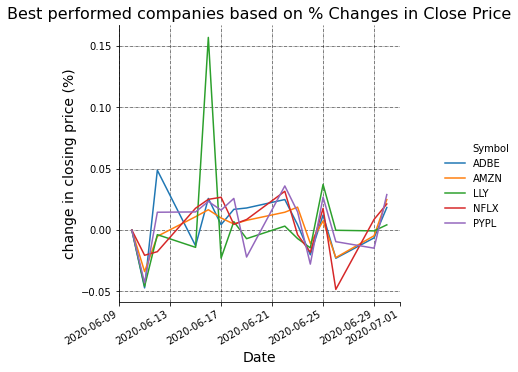

In [27]:
CreatePctPlotAndSavefig(tickers_bestPerformed.index, 'Best performed companies based on % Changes in Close Price', 'change in closing price (%)', 'highest growth closing pct change')

## Volatility

### most volatiled companies. (based on the standard deviation of percentage change)

#### Top 5 companies with highest volatillity rates among S&P 100

In [28]:
tickers_volatile = df_temp['Close'].describe().transpose().sort_values(by='std', ascending=False).head(5)#.round(2)
tickers_volatile = format_column_percentage(tickers_volatile, tickers_volatile.columns[1:])

In [29]:
tickers_volatile.index

Index(['BA', 'OXY', 'SPG', 'C', 'LLY'], dtype='object', name='Symbol')

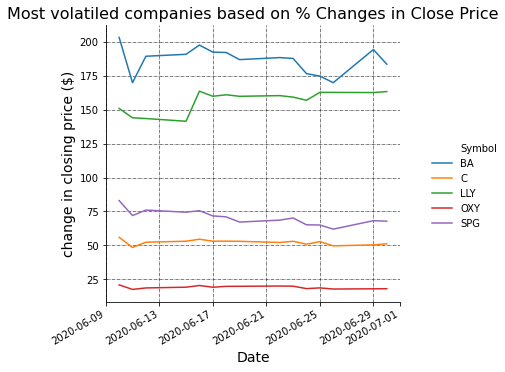

In [30]:
CreatePlotAndSavefig(tickers_volatile.index, 'Most volatiled companies based on % Changes in Close Price', 'change in closing price ($)', '2')

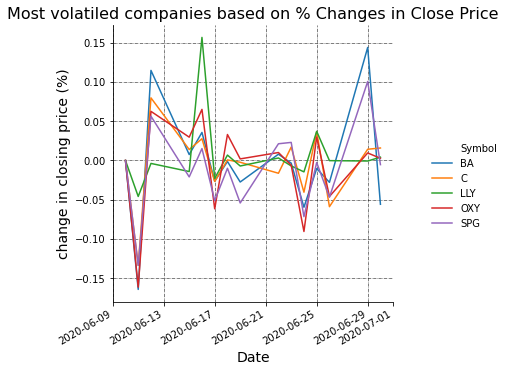

In [31]:
CreatePctPlotAndSavefig(tickers_volatile.index, 'Most volatiled companies based on % Changes in Close Price', 'change in closing price (%)', '1')

## Get date where highest drop and raise of closing price occured. 

In [32]:
highest_raise = df_Flat_pct_change.groupby(['Symbol'])['Close'].transform(max) == df_Flat_pct_change['Close']
df_Flat_pct_change[highest_raise]

,Symbol,Date,High,Low,Open,Close,Volume,Adj Close
4,AAPL,2020-06-16,0.021754,0.036503,0.054644,0.026502,0.191775,0.026502
19,ABBV,2020-06-16,0.023078,0.029742,0.039334,0.032015,0.315427,0.032015
41,ABT,2020-06-25,-0.010140,-0.007602,-0.037405,0.026575,-0.058744,0.026575
56,ACN,2020-06-25,0.050579,0.054863,0.036446,0.076694,0.703236,0.076694
62,ADBE,2020-06-12,0.018605,0.020755,0.023250,0.048675,1.019837,0.048675
...,...,...,...,...,...,...,...,...
1453,VZ,2020-06-29,0.012024,0.008704,-0.013509,0.028781,-0.473026,0.028781
1462,WBA,2020-06-19,0.048292,0.019816,0.019194,0.051215,3.273216,0.051215
1481,WFC,2020-06-25,0.014058,-0.003848,-0.037092,0.047856,-0.213986,0.047856
1492,WMT,2020-06-19,0.010415,0.000765,0.002953,0.015764,0.996951,0.015764


In [33]:
highest_drop = df_Flat_pct_change.groupby(['Symbol'])['Close'].transform(min) == df_Flat_pct_change['Close']
drops = df_Flat_pct_change[highest_drop]

In [34]:
drops

,Symbol,Date,High,Low,Open,Close,Volume,Adj Close
1,AAPL,2020-06-11,-0.010457,-0.030657,0.004053,-0.048010,0.210084,-0.048010
16,ABBV,2020-06-11,-0.024761,-0.049277,-0.013403,-0.047884,0.129867,-0.047884
31,ABT,2020-06-11,-0.002695,-0.040821,0.014529,-0.047526,0.401297,-0.047526
46,ACN,2020-06-11,-0.023147,-0.048664,-0.008395,-0.064365,0.948103,-0.064365
61,ADBE,2020-06-11,-0.014098,-0.030339,0.001026,-0.047072,0.141793,-0.047072
...,...,...,...,...,...,...,...,...
1441,VZ,2020-06-11,-0.004980,-0.022530,-0.007254,-0.027562,0.715315,-0.027562
1456,WBA,2020-06-11,-0.053669,-0.078924,-0.051406,-0.079720,0.731859,-0.079720
1471,WFC,2020-06-11,-0.120631,-0.099494,-0.157895,-0.098283,-0.078800,-0.098283
1487,WMT,2020-06-12,-0.014929,-0.020254,-0.003967,-0.019569,-0.053260,-0.019569


In [35]:
drops['DateStr'] = drops['Date'].apply(lambda x: x.strftime('%Y/%m/%d'))

/Users/reejungkim/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [36]:
drops['search_key'] = drops['Symbol']  + ' ' + drops['DateStr']

/Users/reejungkim/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## Search and scrap what happened to the stock on the date

In [37]:
search_list = drops.loc[drops['Symbol'].isin (tickers_bestPerformed.index)]['search_key'].tolist()

In [38]:
search_list

['ADBE 2020/06/11',
 'AMZN 2020/06/11',
 'LLY 2020/06/11',
 'NFLX 2020/06/26',
 'PYPL 2020/06/11']

In [39]:
driver = webdriver.Chrome('/Users/reejungkim/opt/anaconda3/libexec/chromedriver')  
driver.get('https://news.google.com/topstories?hl=en-GB&tab=wn&gl=GB&ceid=GB:en')
driver.implicitly_wait(3)

In [40]:
xpath = '//*[@id="gb"]/div[2]/div[2]/div/form/div[1]/div/div/div/div/div[1]/input[2]'
search = driver.find_element_by_xpath(xpath)

In [41]:
titles = []
links = []
searched=[]

for keyword in search_list:
    driver.implicitly_wait(30)
    search.clear()
    search.send_keys(keyword)
    search.send_keys(Keys.ENTER)
    driver.implicitly_wait(30)

    url = driver.current_url
    resp = requests.get(url)
    soup = BeautifulSoup(resp.text, 'lxml')

    for link in soup.select('h3 >a')[:5]:
        href = 'https://news.google.com' + link.get('href')[1:]
        title = link.string
        searched.append(keyword)
        titles.append(title)
        links.append(href)
    
    search.clear()

In [42]:
news_data = { 'searched keyword': searched, 'title': titles, 'link': links}
news_df = pd.DataFrame(news_data, columns=['searched keyword','title', 'link'])

news_df['link'] = "<a href=" + "\"{" + news_df['link'] + "}" + "\"" + ">Click</a>"

In [43]:
news_df

,searched keyword,title,link
0,ADBE 2020/06/11,How Cloud Solutions Brought Adobe to the Top,https://news.google.com/articles/CBMiW2h0dHBzO...
1,ADBE 2020/06/11,Adobe stock rises as coronavirus work-from-hom...,https://news.google.com/articles/CAIiEEKuzfAQn...
2,ADBE 2020/06/11,"7 Stocks To Watch For June 11, 2020",https://news.google.com/articles/CBMiWGh0dHBzO...
3,ADBE 2020/06/11,Edited Transcript of ADBE earnings conference ...,https://news.google.com/articles/CBMiWGh0dHBzO...
4,ADBE 2020/06/11,S&P 500 Earnings Preview - Adobe Headlines Thu...,https://news.google.com/articles/CBMidGh0dHBzO...
5,AMZN 2020/06/11,Better Buy: Amazon.com vs. Walmart,https://news.google.com/articles/CBMiTmh0dHBzO...
6,AMZN 2020/06/11,Amazon to reportedly face antitrust charges in...,https://news.google.com/articles/CAIiELZlMcewN...
7,AMZN 2020/06/11,"Dow rises more than 400 points, but Wall Stree...",https://news.google.com/articles/CAIiEADs7woBV...
8,AMZN 2020/06/11,Ex Amazon VP who called company 'chickens--t' ...,https://news.google.com/articles/CAIiECZ6ylkhP...
9,AMZN 2020/06/11,Stocks making the biggest moves in the premark...,https://news.google.com/articles/CAIiEHgL8BRnh...


In [44]:
news_df.to_csv('./news.csv')

#Open pdf file generated
subprocess.run(['open', './news.csv'], check=True)

## S&P 100 total

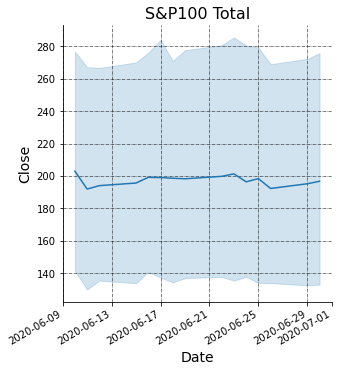

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.relplot(x='Date', y='Close', kind='line', data=df_Flat).fig.autofmt_xdate()

plt.grid(which="major", color='k', linestyle='-.', linewidth=0.5)
plt.title('S&P100 Total', fontsize=16)
plt.ylabel('Close', fontsize=14)
plt.xlabel('Date', fontsize=14)

jpg_name = 'SP100_total.jpg'
plt.savefig(jpg_name, bbox_inches='tight')

pd.options.display.float_format = '{:,.2%}'.format
display(tickers_volatile), display(tickers_bestPerformed)

In [46]:
#pd.options.display.float_format = '{:,.2f}'.format
dataToExport = df.loc[tickers_bestPerformed.index].unstack(0).describe()
dataToExport = dataToExport.transpose().reset_index().groupby(['Symbol', 'level_0']).sum().round(2)

dataToExport.rename_axis(index={"level_0":"Type"}, inplace=True)
dataToExport

count        mean         std         min         25%  \
Symbol Type                                                               
ADBE   Adj Close   15.0      420.46       15.41      387.67      409.25   
       Close       15.0      420.46       15.41      387.67      409.25   
       High        15.0      425.28       14.02      404.20      413.20   
       Low         15.0      414.20       14.50      387.37      402.49   
       Open        15.0      419.71       14.53      398.80      408.56   
       Volume      15.0  3458332.13  1560385.16  1363782.00  2600850.00   
AMZN   Adj Close   15.0     2666.38       71.09     2545.02     2628.12   
       Close       15.0     2666.38       71.09     2545.02     2628.12   
       High        15.0     2700.53       65.21     2584.00     2657.32   
       Low         15.0     2632.67       72.27     2503.35     2601.13   
       Open        15.0     2669.94       68.61     2526.60     2632.50   
       Volume      15.0  4180713.67  1307482.49  2214605.00  3088750.00   
LLY    Adj Close   15.0      156.90        7.85      141.52      154.01   
       Close       15.0      156.90        7.85      141.52      154.01   
       High        15.0      159.38        7.32      142.90      156.09   
       Low         15.0      154.62        7.45      139.68      152.42   
       Open        15.0      157.13        6.83      142.00      154.09   
       Volume      15.0  4528906.67  3150040.09  1206800.00  2933750.00   
NFLX   Adj Close   15.0      446.44       15.77      418.07      435.31   
       Close       15.0      446.44       15.77      418.07      435.31   
       High        15.0      453.03       14.76      426.49      442.63   
       Low         15.0      438.91       15.25      412.45      427.86   
       Open        15.0      446.04       15.50      421.40      432.50   
       Volume      15.0  5392840.87  1275586.27  2538113.00  4647050.00   
PYPL   Adj Close   15.0      165.28        6.60      153.04      160.57   
       Close       15.0      165.28        6.60      153.04      160.57   
       High        15.0      167.63        6.41      157.21      161.86   
       Low         15.0      162.33        6.32      151.89      157.95   
       Open        15.0      165.14        6.66      152.63      159.26   
       Volume      15.0  7152450.53  1945514.14  3527558.00  5730800.00   

                         50%         75%          max  
Symbol Type                                            
ADBE   Adj Close      424.20      431.83       440.55  
       Close          424.20      431.83       440.55  
       High           428.48      438.08       446.15  
       Low            416.03      426.09       436.01  
       Open           423.76      429.49       440.07  
       Volume     3329400.00  3805600.00   8329200.00  
AMZN   Adj Close     2675.01     2724.11      2764.41  
       Close         2675.01     2724.11      2764.41  
       High          2697.43     2751.56      2796.00  
       Low           2636.11     2681.52      2721.00  
       Open          2678.08     2708.02      2780.00  
       Volume     4217200.00  5187800.00   6500800.00  
LLY    Adj Close      159.97      162.78       163.71  
       Close          159.97      162.78       163.71  
       High           162.87      163.93       167.43  
       Low            158.20      159.17       162.33  
       Open           159.18      162.28       164.23  
       Volume     3735400.00  4824800.00  15029300.00  
NFLX   Adj Close      447.77      457.29       468.04  
       Close          447.77      457.29       468.04  
       High           452.76      467.52       474.01  
       Low            442.24      450.57       464.50  
       Open           448.73      456.93       468.54  
       Volume     5507900.00  6364750.00   7462900.00  
PYPL   Adj Close      168.00      170.56       173.21  
       Close          168.00      170.56       173.21  
       High           170.90      173.13       17

In [47]:
#format_column_percentage(dataToExport, dataToExport.columns[1:])

dataToExport2 = df.loc[tickers_bestPerformed.index].unstack(0).describe().stack(0)
dataToExport2

# Create PDF file

In [48]:
today = dt.datetime.today().strftime('%Y-%m-%d')
pdf_file_name = "Report "+ today +".pdf"

In [49]:
def PrepareTableForReportLab(dataframe):
    
    data = dataframe

    'handling grouped first index column'
    a= []
    for i in range(len(data)):
        #print(i, data.index.get_level_values(0)[i])
        if data.index.get_level_values(0)[i-1] == data.index.get_level_values(0)[i]:
            a.append(i)
    a.sort(reverse=True)

    as_list = data.index.get_level_values(0).tolist()
    for i in a:
        as_list[i] = ""

        
    'flat dataframe'
    data = data.reset_index()
    'remove duplicated values from first column which was index before resetting index'
    first_col_name = data.columns[0]
    data[first_col_name] = as_list 
    
    #data = dataframe.reset_index()
    #colwidths = 800/len(data.columns) 
    data = [data.columns.to_list()] + data.values.tolist() 

    #tbl = Table(data) # 
    tbl = Table(data) #, colwidths ) #, rowheights)
    tbl.setStyle(TableStyle([
    ('INNERGRID', (0, 0), (-1, -1), 0.25, colors.black),
    ('BOX', (0, 0), (-1, -1), 0.25, colors.black),
    ('ALIGN', (1,1), (-1,-1), 'RIGHT'),
    ('BACKGROUND', (0,0), (-1,0), colors.Color(0,0.7,0.7))
    ]))
    
    return tbl

def PrepareTableForReportLab_News_df(dataframe):
    
    data = dataframe

    'handling grouped first index column'
    a= []
    for i in range(len(data)):
        #print(i, data.index.get_level_values(0)[i])
        if data.index.get_level_values(0)[i-1] == data.index.get_level_values(0)[i]:
            a.append(i)
    a.sort(reverse=True)

    as_list = data.index.get_level_values(0).tolist()
    for i in a:
        as_list[i] = ""

        
    'flat dataframe'
    data = data.reset_index()
    'remove duplicated values from first column which was index before resetting index'
    first_col_name = data.columns[0]
    data[first_col_name] = as_list 
    
    #data = dataframe.reset_index()
    colwidths = 800/len(data.columns) 
    rowheights = 1.5*inch
    data = [data.columns.to_list()] + data.values.tolist() 

    #tbl = Table(data) # 
    tbl = Table(data , colwidths, rowheights)
    tbl.setStyle(TableStyle([
    ('INNERGRID', (0, 0), (-1, -1), 0.25, colors.black),
    ('BOX', (0, 0), (-1, -1), 0.25, colors.black),
    ('ALIGN', (1,1), (-1,-1), 'RIGHT'),
    ('BACKGROUND', (0,0), (-1,0), colors.Color(0,0.7,0.7))
    ]))
    
    return tbl

In [50]:
story = []

In [51]:
story.append(Paragraph("Highest growth rates", getSampleStyleSheet()['Heading1']))
story.append(Paragraph("highest growth rates in past <i>" + str(days_to_lookback) + " days</i>.",  getSampleStyleSheet()['Normal']))
story.append(Spacer(1,20))
story.append((PrepareTableForReportLab(dataToExport)))
story.append(Spacer(1,20))
story.append(PrepareTableForReportLab(tickers_bestPerformed))
story.append(PageBreak())

story.append(Paragraph("Volatility", getSampleStyleSheet()['Heading1']))
story.append(Paragraph("highest volatility rates in past <i>" + str(days_to_lookback)  + " days</i>.",  getSampleStyleSheet()['Normal']))
story.append(Spacer(1,20))
story.append(PrepareTableForReportLab(tickers_volatile))
story.append(PageBreak())

#### Add graph images saved in the timestamped folder

In [52]:
for file in sorted(os.listdir(reportDir), key=os.path.getmtime):
    if file.endswith('jpg'):
        temp = file
        temp = 'image_'+ temp
        print(temp)
        temp = Image(file)
        #story.append(Spacer(1, 20))
        story.append(temp)

image_highest growth closing price.jpg
image_highest growth closing pct change.jpg
image_2.jpg
image_1.jpg
image_SP100_total.jpg


story.append(PageBreak())
story.append(PrepareTableForReportLab_News_df(news_df))

In [53]:
doc = SimpleDocTemplate(pdf_file_name, pagesize = landscape(letter), topMargin = inch * .25, bottomMargin = inch * .25)
doc.build(story)

In [54]:
#open folder
subprocess.run(['open', reportDir], check=True)

CompletedProcess(args=['open', '/Users/reejungkim/Documents/Git/reporting automation/2020-06-30 19-34-17'], returncode=0)

In [55]:
#Open pdf file generated
subprocess.run(['open', pdf_file_name], check=True)

CompletedProcess(args=['open', 'Report 2020-06-30.pdf'], returncode=0)